In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from prophet import Prophet


In [4]:
df = pd.read_csv('AAPL.csv')

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100323,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095089,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088110,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090291,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092908,73449600


In [6]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
10404,2022-03-18,160.509995,164.479996,159.759995,163.979996,163.979996,123351200
10405,2022-03-21,163.509995,166.350006,163.009995,165.380005,165.380005,95811400
10406,2022-03-22,165.509995,169.419998,164.910004,168.820007,168.820007,81532000
10407,2022-03-23,167.990005,172.639999,167.649994,170.210007,170.210007,98062700
10408,2022-03-24,171.059998,174.139999,170.210007,174.070007,174.070007,90018700


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10409 entries, 0 to 10408
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10409 non-null  object 
 1   Open       10409 non-null  float64
 2   High       10409 non-null  float64
 3   Low        10409 non-null  float64
 4   Close      10409 non-null  float64
 5   Adj Close  10409 non-null  float64
 6   Volume     10409 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 569.4+ KB


In [8]:
df.size

72863

In [9]:
df.shape

(10409, 7)

In [10]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [11]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100323,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095089,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088110,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090291,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092908,73449600


In [12]:
print("\nDataset Info:")
print(f"Date Range: {df.index.min()} to {df.index.max()}")
print(f"Total Trading Days: {len(df)}")
print(f"Years of Data: {(df.index.max() - df.index.min()).days / 365.25:.1f}")


Dataset Info:
Date Range: 1980-12-12 00:00:00 to 2022-03-24 00:00:00
Total Trading Days: 10409
Years of Data: 41.3


In [13]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [14]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,10409.000000,10409.000000,10409.000000,10409.000000,10409.000000,1.040900e+04
mean,13.959910,14.111936,13.809163,13.966757,13.350337,3.321778e+08
std,30.169244,30.514878,29.835055,30.191696,29.911132,3.393344e+08
min,0.049665,0.049665,0.049107,0.049107,0.038384,0.000000e+00
25%,0.281964,0.287946,0.274554,0.281250,0.234799,1.247604e+08
50%,0.468750,0.477679,0.459821,0.468750,0.386853,2.199680e+08
75%,14.217857,14.364286,14.043571,14.206071,12.188149,4.126108e+08
max,182.630005,182.940002,179.119995,182.009995,181.778397,7.421641e+09


In [15]:
def check_data_quality(df):
    issues = []

    # Negative prices
    if (df[['Open','High','Low','Close','Adj Close']] < 0).any().any():
        issues.append("Negative prices found")

    # High >= Open, Close, Low
    if (df['High'] < df[['Open','Close','Low']].max(axis=1)).any():
        issues.append("High price inconsistency found")

    # Low <= Open, Close, High
    if (df['Low'] > df[['Open','Close','High']].min(axis=1)).any():
        issues.append("Low price inconsistency found")

    # Zero volume
    zero_vol = (df['Volume'] == 0).sum()
    if zero_vol:
        issues.append(f"Zero volume found on {zero_vol} days")

    return issues

# Run check
issues = check_data_quality(df)
print("Data Quality Issues Found:" if issues else "No major issues found!")
for i in issues:
    print("-", i)

Data Quality Issues Found:
- Zero volume found on 1 days


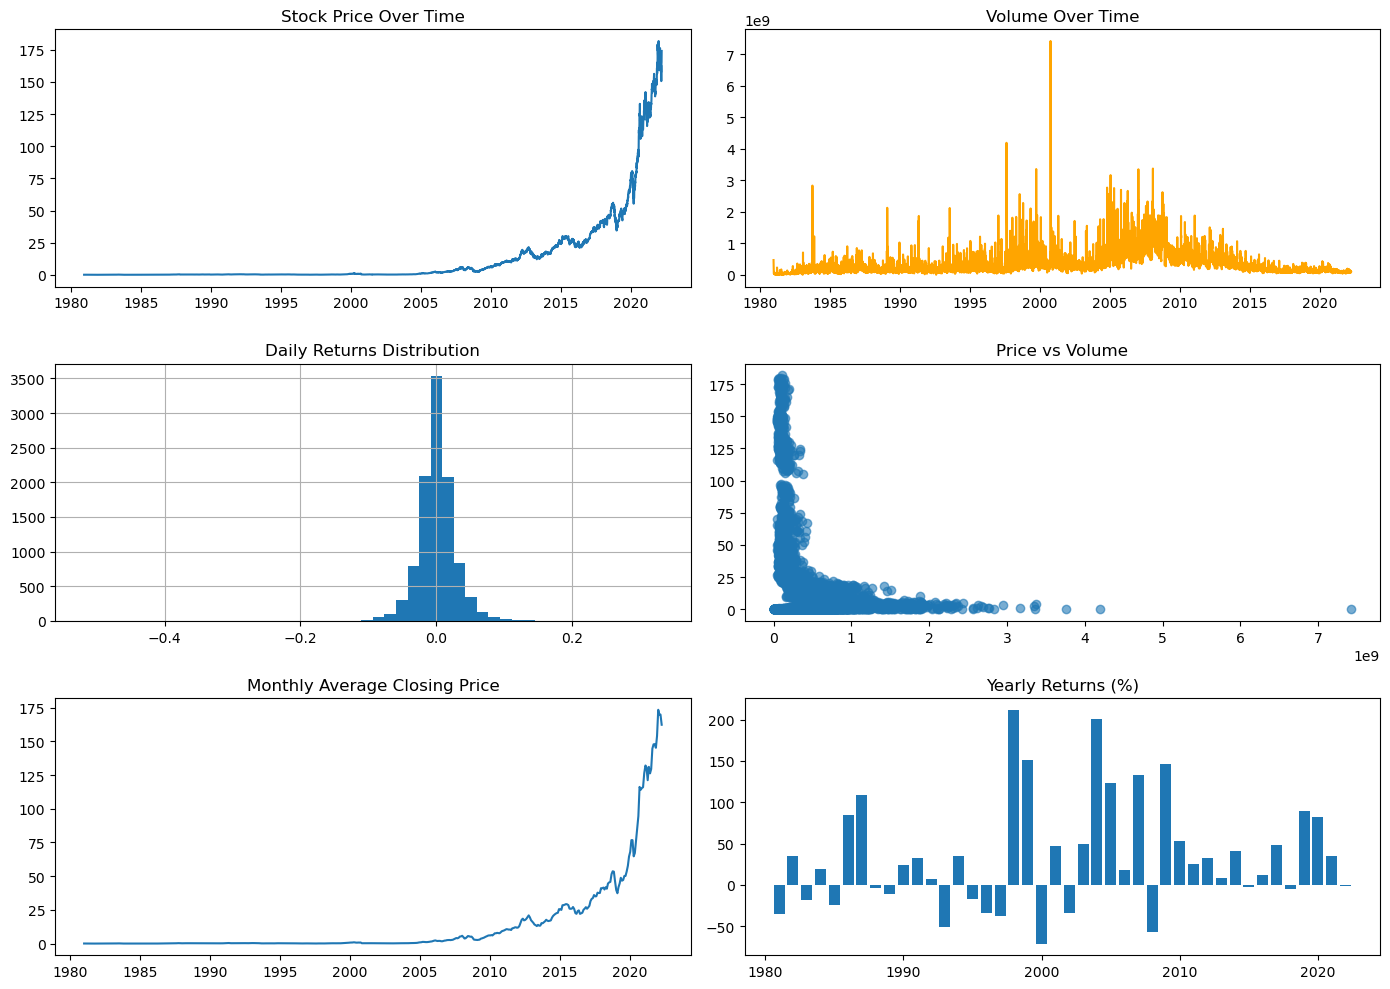

In [16]:
import matplotlib.pyplot as plt

# Daily returns
df['Daily_Return'] = df['Adj Close'].pct_change()

# Monthly average & Yearly returns
monthly_avg = df['Adj Close'].resample('M').mean()
yearly_returns = df['Adj Close'].resample('Y').last().pct_change()

plt.figure(figsize=(14,10))

# 1. Stock price
plt.subplot(3,2,1)
plt.plot(df['Adj Close'])
plt.title("Stock Price Over Time")

# 2. Volume
plt.subplot(3,2,2)
plt.plot(df['Volume'], color='orange')
plt.title("Volume Over Time")

# 3. Daily returns distribution
plt.subplot(3,2,3)
df['Daily_Return'].hist(bins=50)
plt.title("Daily Returns Distribution")

# 4. Price vs Volume
plt.subplot(3,2,4)
plt.scatter(df['Volume'], df['Adj Close'], alpha=0.6)
plt.title("Price vs Volume")

# 5. Monthly average close
plt.subplot(3,2,5)
plt.plot(monthly_avg)
plt.title("Monthly Average Closing Price")

# 6. Yearly returns
plt.subplot(3,2,6)
plt.bar(yearly_returns.index.year, yearly_returns.values*100)
plt.title("Yearly Returns (%)")

plt.tight_layout()
plt.show()

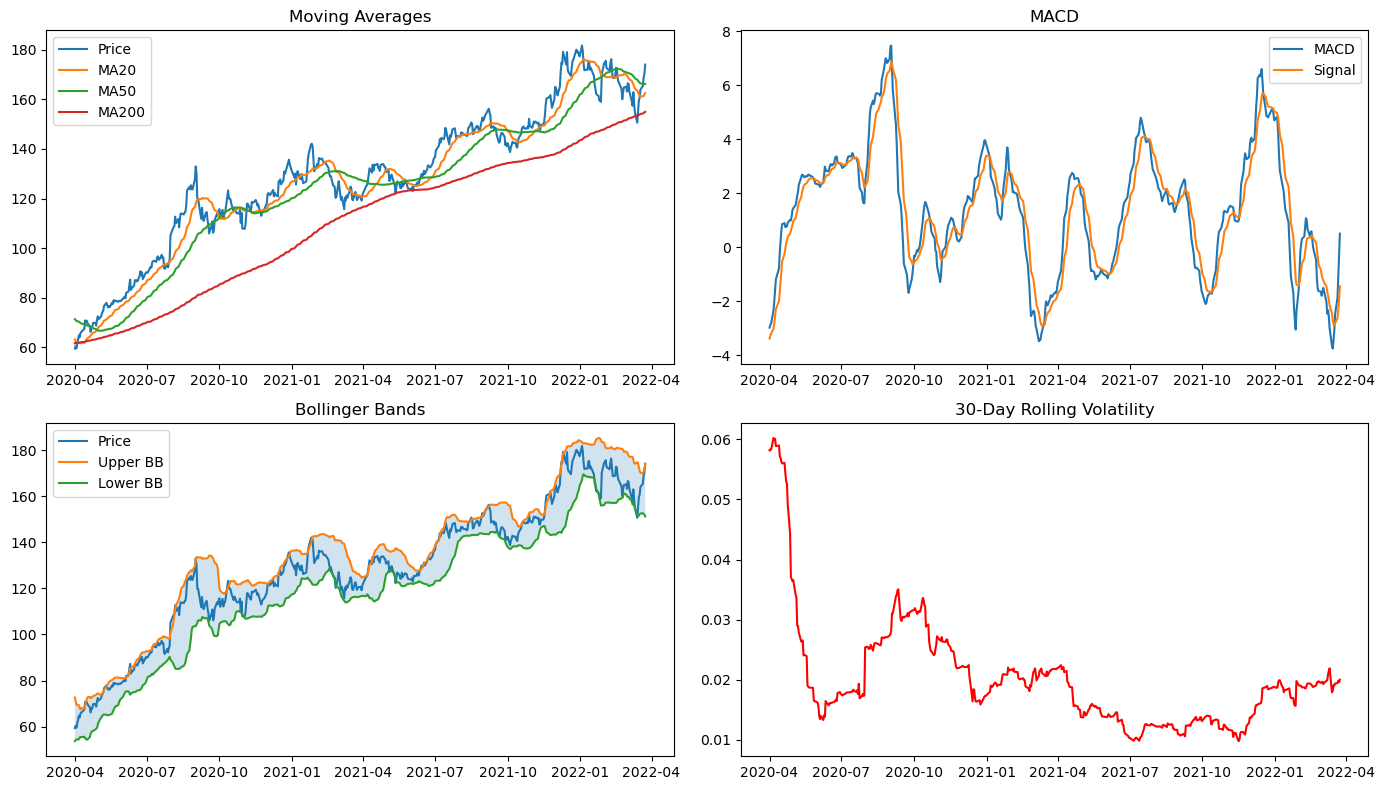

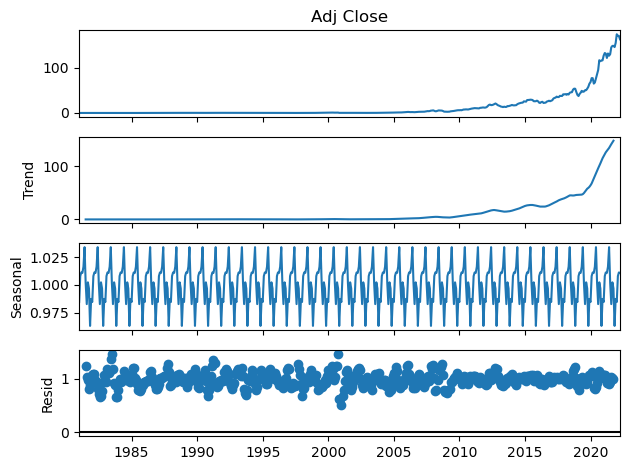

In [17]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# --- FEATURE ENGINEERING ---
def create_features(df):
    df = df.copy()
    df['Daily_Return'] = df['Adj Close'].pct_change()

    # Moving Averages
    for window in [20, 50, 200]:
        df[f'MA_{window}'] = df['Adj Close'].rolling(window).mean()

    # EMAs & MACD
    df['EMA_12'] = df['Adj Close'].ewm(span=12).mean()
    df['EMA_26'] = df['Adj Close'].ewm(span=26).mean()
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['MACD_signal'] = df['MACD'].ewm(span=9).mean()

    # Bollinger Bands
    ma20 = df['Adj Close'].rolling(20).mean()
    std20 = df['Adj Close'].rolling(20).std()
    df['BB_upper'] = ma20 + (2 * std20)
    df['BB_lower'] = ma20 - (2 * std20)

    # Volatility
    df['Volatility'] = df['Daily_Return'].rolling(30).std()

    # Time features
    df['Year'], df['Month'], df['Quarter'] = df.index.year, df.index.month, df.index.quarter

    # Lags
    for lag in [1, 2, 3, 5, 10]:
        df[f'Close_lag_{lag}'] = df['Adj Close'].shift(lag)

    return df

df_features = create_features(df)

# --- VISUALIZATION ---
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# 1. Moving Averages
axes[0,0].plot(df_features['Adj Close'][-500:], label='Price')
axes[0,0].plot(df_features['MA_20'][-500:], label='MA20')
axes[0,0].plot(df_features['MA_50'][-500:], label='MA50')
axes[0,0].plot(df_features['MA_200'][-500:], label='MA200')
axes[0,0].legend(); axes[0,0].set_title("Moving Averages")

# 2. MACD
axes[0,1].plot(df_features['MACD'][-500:], label='MACD')
axes[0,1].plot(df_features['MACD_signal'][-500:], label='Signal')
axes[0,1].legend(); axes[0,1].set_title("MACD")

# 3. Bollinger Bands
axes[1,0].plot(df_features['Adj Close'][-500:], label='Price')
axes[1,0].plot(df_features['BB_upper'][-500:], label='Upper BB')
axes[1,0].plot(df_features['BB_lower'][-500:], label='Lower BB')
axes[1,0].fill_between(df_features.index[-500:],
                       df_features['BB_upper'][-500:], df_features['BB_lower'][-500:], alpha=0.2)
axes[1,0].legend(); axes[1,0].set_title("Bollinger Bands")

# 4. Volatility
axes[1,1].plot(df_features['Volatility'][-500:], color='red')
axes[1,1].set_title("30-Day Rolling Volatility")

plt.tight_layout()
plt.show()

# --- SEASONAL DECOMPOSITION ---
monthly_prices = df_features['Adj Close'].resample('M').mean()
decomp = seasonal_decompose(monthly_prices, model='multiplicative', period=12)
decomp.plot(); plt.show()

Adj Close Prices | p-value: 1.0000
Daily Returns | p-value: 0.0000


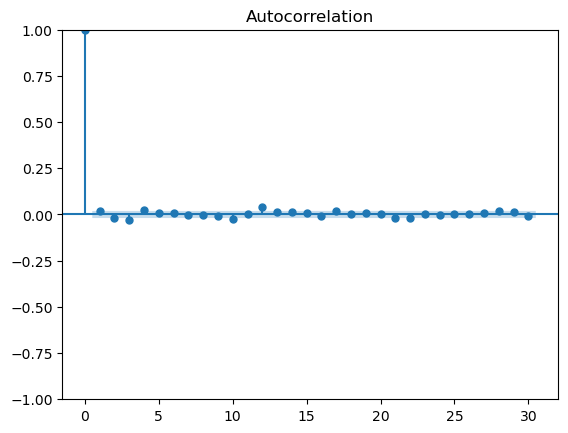

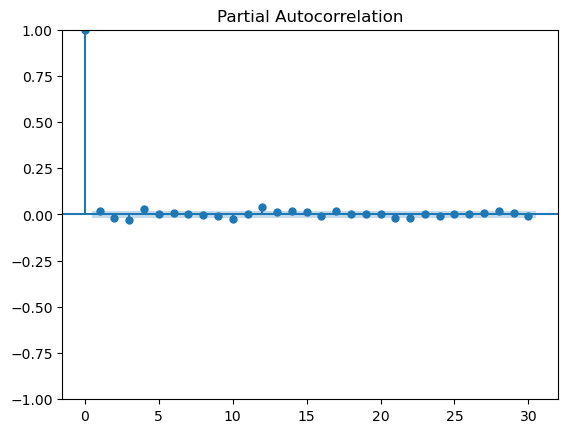

Next 30 days ARIMA forecast:
10409    174.155705
10410    174.101461
10411    174.073781
10412    174.102946
10413    174.109701
10414    174.095543
10415    174.095217
10416    174.101535
10417    174.100492
10418    174.097896
10419    174.098844
10420    174.099814
10421    174.099212
10422    174.098897
10423    174.099222
10424    174.099300
10425    174.099142
10426    174.099137
10427    174.099208
10428    174.099197
10429    174.099168
10430    174.099178
10431    174.099189
10432    174.099182
10433    174.099179
10434    174.099182
10435    174.099183
10436    174.099182
10437    174.099181
10438    174.099182
Name: predicted_mean, dtype: float64

Next 12 months SARIMA forecast:
2022-04-30    163.757675
2022-05-31    168.803084
2022-06-30    166.487642
2022-07-31    167.512656
2022-08-31    174.748316
2022-09-30    177.377370
2022-10-31    175.136879
2022-11-30    181.861047
2022-12-31    182.991095
2023-01-31    188.852506
2023-02-28    191.362830
2023-03-31    194.068626
F

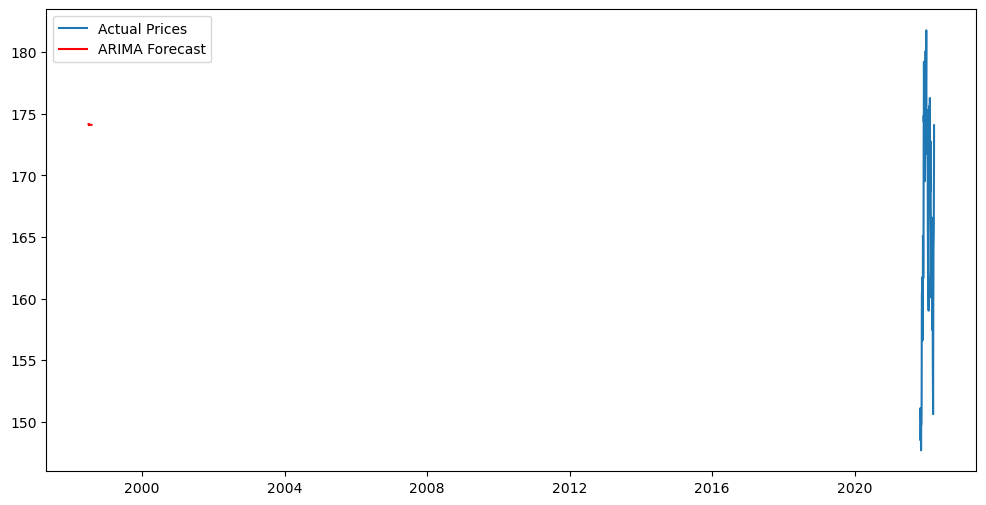

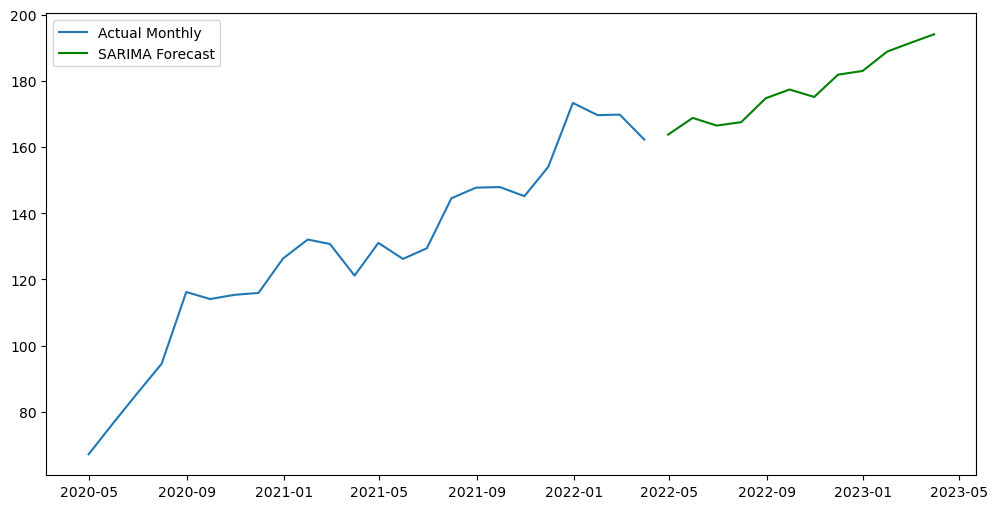

In [18]:
def check_stationarity(series, name):
    result = adfuller(series.dropna())
    print(f"{name} | p-value: {result[1]:.4f}")
    return result[1] <= 0.05

# Use Adjusted Close
prices = df['Adj Close']
returns = prices.pct_change()

check_stationarity(prices, "Adj Close Prices")
check_stationarity(returns, "Daily Returns")

#  ARIMA Model

log_prices = np.log(prices).dropna()
log_diff = log_prices.diff().dropna()

plot_acf(log_diff, lags=30)
plot_pacf(log_diff, lags=30)
plt.show()

# Fit ARIMA (example: (2,1,2))
model = ARIMA(log_prices, order=(2,1,2))
arima_fit = model.fit()

forecast = arima_fit.forecast(steps=30)
forecast_exp = np.exp(forecast)

print("Next 30 days ARIMA forecast:")
print(forecast_exp)

#  SARIMA Model

monthly_prices = prices.resample('M').mean()
log_monthly = np.log(monthly_prices).dropna()

sarima = SARIMAX(log_monthly, order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_fit = sarima.fit()

sarima_forecast = np.exp(sarima_fit.forecast(steps=12))
print("\nNext 12 months SARIMA forecast:")
print(sarima_forecast)

#  Plot Results

plt.figure(figsize=(12,6))
plt.plot(prices[-100:], label="Actual Prices")
plt.plot(forecast_exp, label="ARIMA Forecast", color="red")
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(monthly_prices[-24:], label="Actual Monthly")
plt.plot(sarima_forecast, label="SARIMA Forecast", color="green")
plt.legend()
plt.show()

ARIMA(2,1,2) Evaluation on hold-out set:
MAE  : 8.7238
MSE  : 113.4134
RMSE : 10.6496
MAPE : 5.39%


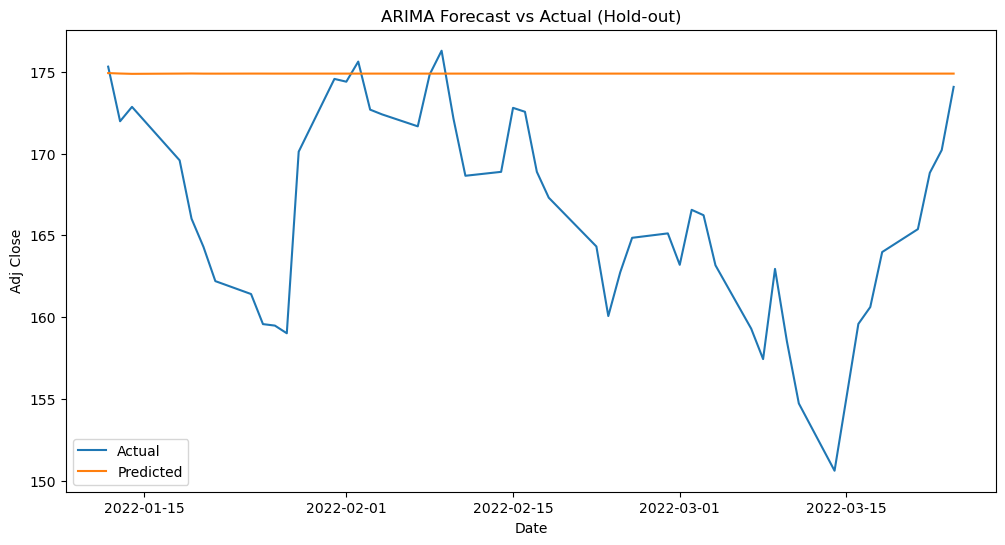

In [19]:
# ---- ARIMA: Train/Test split evaluation ----
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Make sure "prices" is a clean, DateTime-indexed series
prices = prices.dropna()
if not isinstance(prices.index, pd.DatetimeIndex):
    raise ValueError("prices index is not a DatetimeIndex. Set Date as index first.")

prices = prices.sort_index()

# Ensure strictly positive before log
if (prices <= 0).any():
    raise ValueError("prices contains non-positive values; cannot take log. Filter/fix the data first.")

# 2) Choose test size (last N points)
N = min(50, max(10, len(prices)//10))  # default: 10% of data, capped at 50 for speed
train = prices.iloc[:-N]
test  = prices.iloc[-N:]

# 3) Fit ARIMA(p,d,q) on LOG(train) to match your earlier approach
from statsmodels.tsa.arima.model import ARIMA
arima_eval = ARIMA(np.log(train), order=(2,1,2)).fit()

# 4) Forecast next N steps, then exponentiate back
forecast_log = arima_eval.forecast(steps=N)
forecast = np.exp(forecast_log)
forecast.index = test.index  # align indices for plotting/metrics

# 5) Metrics
mae  = mean_absolute_error(test, forecast)
mse  = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast) / test)) * 100

print("ARIMA(2,1,2) Evaluation on hold-out set:")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.2f}%")

# 6) Plot Actual vs Predicted
plt.figure(figsize=(12,6))
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, forecast, label="Predicted")
plt.title("ARIMA Forecast vs Actual (Hold-out)")
plt.xlabel("Date"); plt.ylabel("Adj Close")
plt.legend()
plt.show()


SARIMA(1, 1, 1)x(1, 1, 1, 12) Evaluation on hold-out set:
MAE  : 13.1131
MSE  : 228.7956
RMSE : 15.1260
MAPE : 8.06%


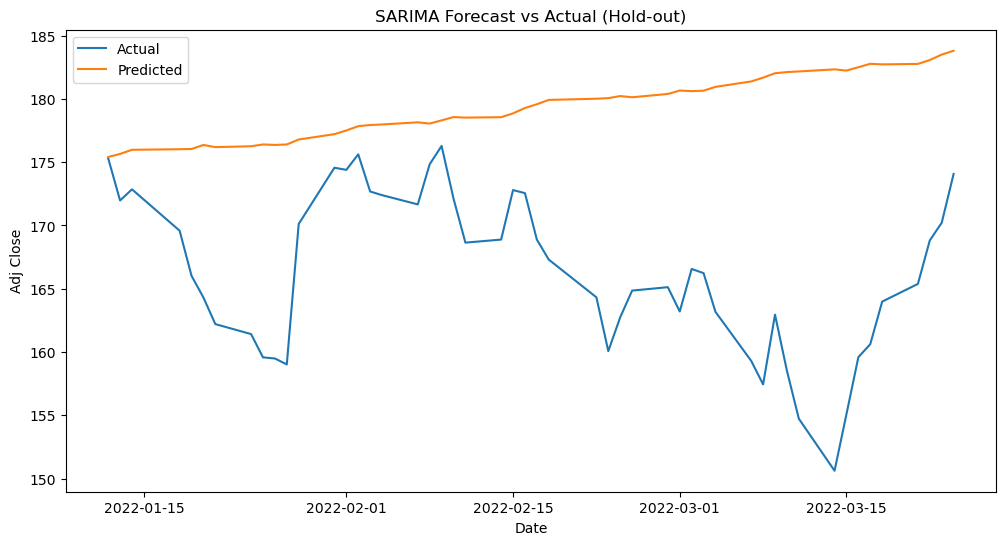

In [20]:
# ---- SARIMA: Train/Test split evaluation ----
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Pre-cleaning
prices = prices.dropna().sort_index()
if (prices <= 0).any():
    raise ValueError("prices contains non-positive values; cannot take log. Filter/fix the data first.")

N = min(50, max(10, len(prices)//10))
train = prices.iloc[:-N]
test  = prices.iloc[-N:]

# SARIMA Params
order = (1,1,1)
seasonal_order = (1,1,1,12)

sarima_eval = SARIMAX(np.log(train),order=order,seasonal_order=seasonal_order,enforce_stationarity=False,
enforce_invertibility=False).fit(disp=False)

forecast_log = sarima_eval.forecast(steps=N)
forecast = np.exp(forecast_log)
forecast.index = test.index

mae  = mean_absolute_error(test, forecast)
mse  = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast) / test)) * 100

print(f"SARIMA{order}x{seasonal_order} Evaluation on hold-out set:")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.2f}%")

plt.figure(figsize=(12,6))
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, forecast, label="Predicted")
plt.title("SARIMA Forecast vs Actual (Hold-out)")
plt.xlabel("Date"); plt.ylabel("Adj Close")
plt.legend()
plt.show()

18:33:21 - cmdstanpy - INFO - Chain [1] start processing
18:33:28 - cmdstanpy - INFO - Chain [1] done processing


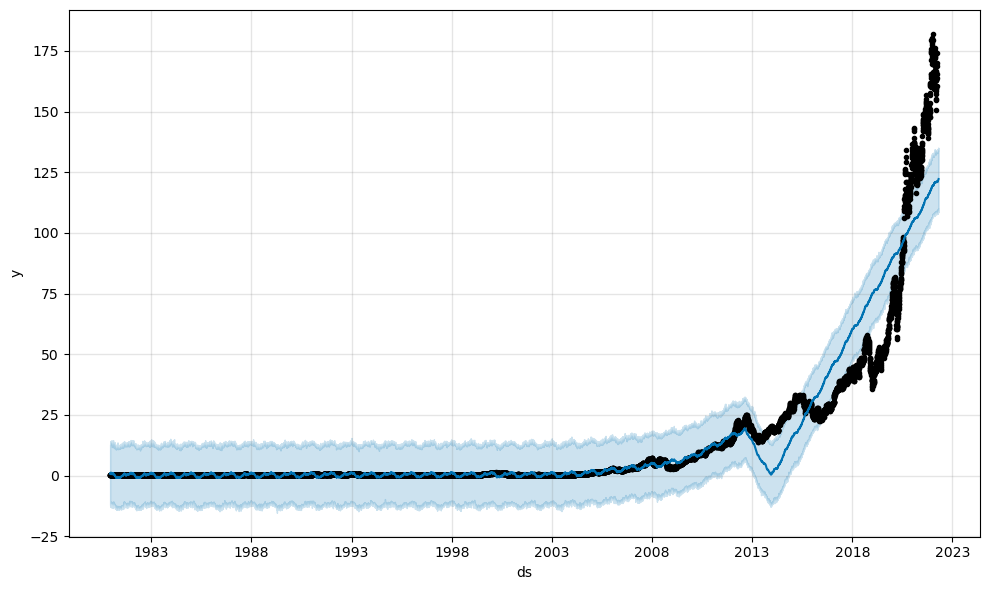

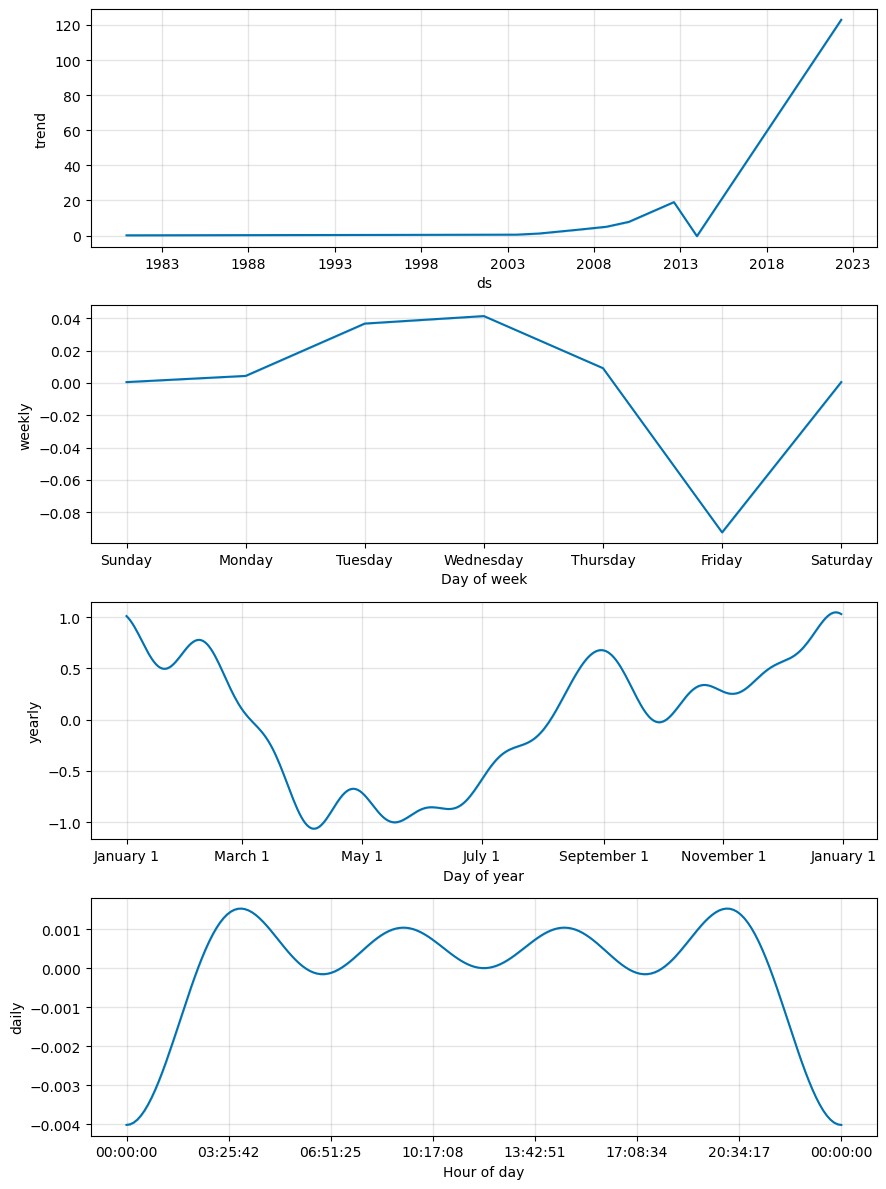

In [21]:
# Prophet Forecasting
from prophet import Prophet
import matplotlib.pyplot as plt

# Prepare data for Prophet (ds = datetime, y = target)
prophet_data = df.reset_index()[['Date', 'Close']]
prophet_data.columns = ['ds', 'y']

# Initialize and fit the model
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(prophet_data)

# Make future predictions (30 days ahead)
future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)

# Plot forecast
fig1 = prophet_model.plot(forecast)
plt.show()

# Plot forecast components (trend, seasonality, etc.)
fig2 = prophet_model.plot_components(forecast)
plt.show()


Epoch 1/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - loss: 3.6582e-05 - val_loss: 9.2229e-04
Epoch 2/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 1.1047e-05 - val_loss: 0.0021
Epoch 3/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 1.2624e-05 - val_loss: 0.0018
Epoch 4/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 9.1619e-06 - val_loss: 0.0015
Epoch 5/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 1.1041e-05 - val_loss: 0.0048
Epoch 6/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 9.3681e-06 - val_loss: 0.0012
Epoch 7/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 1.0413e-05 - val_loss: 0.0017
Epoch 8/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 8.6011e-06 - val_loss: 0.0023
Epoch 9/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 9.3404e-06 - val_loss: 0.0017
Epoch 10/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 9.1956e-06 - val_loss: 0.0022
Epoch 11/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 1.0378e-05 - v

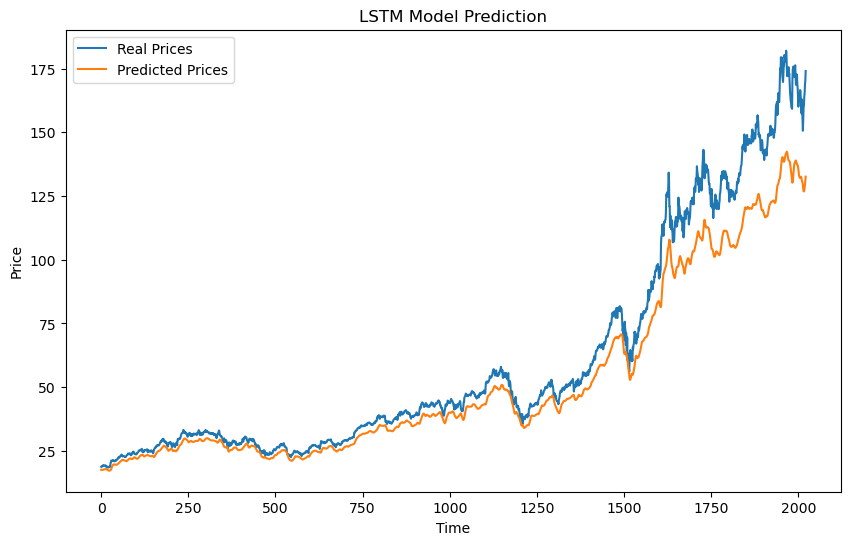

In [22]:
# LSTM Forecasting
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Scale the closing price
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df[['Close']].values)

# Train/test split
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Function to create sequences
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 60
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape for LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Predictions
predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1,1))

# Plot results
plt.figure(figsize=(10,6))
plt.plot(real_prices, label="Real Prices")
plt.plot(predicted_prices, label="Predicted Prices")
plt.title("LSTM Model Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()


In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Prophet predictions only for the test period (not future forecast)
prophet_pred = forecast.set_index('ds').loc[df.index, 'yhat']

# Align lengths
y_true = df['Close']
y_pred = prophet_pred

# Metrics
prophet_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
prophet_mae = mean_absolute_error(y_true, y_pred)
prophet_mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("Prophet Evaluation Metrics")
print(f"RMSE: {prophet_rmse:.4f}")
print(f"MAE : {prophet_mae:.4f}")
print(f"MAPE: {prophet_mape:.2f}%")


Prophet Evaluation Metrics
RMSE: 9.8064
MAE : 4.5751
MAPE: 162.88%


In [24]:
# Evaluation metrics for LSTM
lstm_rmse = np.sqrt(mean_squared_error(real_prices, predicted_prices))
lstm_mae = mean_absolute_error(real_prices, predicted_prices)
lstm_mape = np.mean(np.abs((real_prices - predicted_prices) / real_prices)) * 100

print("LSTM Evaluation Metrics")
print(f"RMSE: {lstm_rmse:.4f}")
print(f"MAE : {lstm_mae:.4f}")
print(f"MAPE: {lstm_mape:.2f}%")


LSTM Evaluation Metrics
RMSE: 12.4119
MAE : 8.3469
MAPE: 11.17%
